In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# IDF Curves - Greece

In the context of the implementation of Water Directive 2007/60 in Greece, formulas of rain curves (parametric relations for calculating the intensity of rainfall for a given duration and return period) were drawn up at the locations of the rainfall stations in each Water Department. You may have a look at the following link:  

The formula required to estimate 

\begin{equation} 
i= \frac{a(T)}{b(d)}
\end{equation}

\begin{equation} 
i(d, T)=\frac{\lambda^{\prime}\left(T^{k}-\psi^{\prime}\right)}{(1+d / \theta)^{\eta}}
\end{equation}

In [2]:
kappa = 0.113
lambda_par = 409.0
psi = 0.607
theta = 0.089
ita = 0.724

def rain_intens(T,d):
    a = lambda_par * (T**kappa - psi)
    b = (1 + d / theta) ** ita
    return a / b

# Vectorizing function
rain_intens_v = np.vectorize(rain_intens)


This formula contains five parameters which can be found in the above mentioned table

# IDF Plots

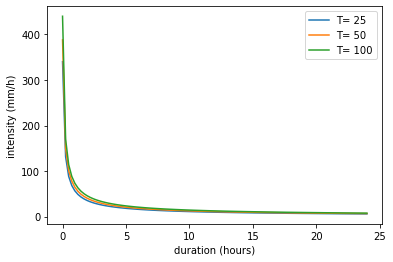

In [3]:
d = np.linspace(0,24,100)
T_array = [25, 50, 100]
for i in T_array:
    y = rain_intens_v(i,d)
    plt.plot(d,y, label='T= '+str(i))

plt.xlabel('duration (hours)')
plt.ylabel('intensity (mm/h)')
plt.legend();
plt.savefig('Results/IDF_Curves.png')

# Alternative Block Method

## Input parameters

In [4]:
# timestep should be in minutes i.e. 5, 10, 15, 10
sel_time_step = 5 # in minutes

# time duration in hours
selected_storm_dur = 8

# selected return period in years
selected_T = 50

timestep_h = sel_time_step / 60
# t is an array of the time steps needed in hours
t = np.linspace(timestep_h, selected_storm_dur, int(selected_storm_dur/timestep_h))
rain_i = rain_intens_v(selected_T, t) * t # rain intensity

storm_duration_min = selected_storm_dur*60
tot_timesteps_min = storm_duration_min / sel_time_step
timesteps_min = np.linspace(sel_time_step, storm_duration_min, int(tot_timesteps_min))

In [5]:
rain_intens_1st_step = np.array([rain_i[0]])
# I also kept the first value besides teh differences
differences = np.diff(rain_i)
rain_intens_steps = np.concatenate((rain_intens_1st_step,differences))
merge_array = np.column_stack((rain_intens_steps, timesteps_min))
rain_steps_df = pd.DataFrame(data = merge_array, index=t,
                         columns=['precip', 'steps'])

## Processing - Alternative block method

In [6]:
atltern_array = np.zeros(rain_steps_df.shape[0]) 
rain_steps_df_sorted = rain_steps_df.sort_values(by='precip', ascending=False)
mean_index = int(rain_steps_df.shape[0] /2)

switch = True
l1 = 1 
l2 = 1
for i in range(rain_steps_df_sorted.shape[0]):
    if  i == 0:
        atltern_array[mean_index] = rain_steps_df_sorted['precip'].iloc[0]
    else:
        if switch == True:
            atltern_array[mean_index - l1] = rain_steps_df_sorted['precip'].iloc[i]
            switch = False
            l1+=1
        else:
            atltern_array[mean_index + l2] = rain_steps_df_sorted['precip'].iloc[i]
            switch = True
            l2+=1 

In [7]:
atltern_ar_merge = np.column_stack((atltern_array, timesteps_min))
atltern_df = pd.DataFrame(atltern_ar_merge, index=t, columns= ['precip (mm)','time_step (min)'])
cols = ['time_step (min)','precip (mm)',]
atltern_df = atltern_df[cols]
atltern_excel = atltern_df.to_excel('Alternating_block_method_app.xlsx',
                                    float_format='%.2f',
                                   index_label='time step (h)')

In [8]:
atltern_df

,time_step (min),precip (mm)
0.083333,5.0,0.352179
0.166667,10.0,0.357769
0.250000,15.0,0.363575
0.333333,20.0,0.369610
0.416667,25.0,0.375889
...,...,...
7.666667,460.0,0.379125
7.750000,465.0,0.372718
7.833333,470.0,0.366563
7.916667,475.0,0.360645


## Plot

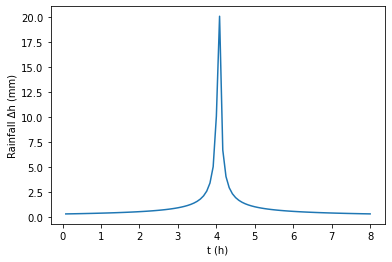

In [9]:
# ploting
plt.plot(atltern_df['precip (mm)'])
plt.xticks(np.arange(0,selected_storm_dur+1,1))
plt.xlabel('t (h)')
plt.ylabel('Rainfall Δh (mm)')
plt.savefig('Results/Alternating_Block_Method.png');